In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.feature_extraction.image import extract_patches_2d


device = torch.device('cuda:0')

In [44]:
class Classifier(nn.Module):
    def __init__(self, in_channels=3,out_classes=10):
        super(Classifier, self).__init__()
        hidden_dim = 256
        self.conv1 = nn.Conv2d(in_channels,hidden_dim,kernel_size=4,stride=2,padding=4)
        self.conv2 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=4,stride=2)
        self.linear_final = nn.Linear(8*8*hidden_dim,out_classes)

    def forward(self,x):
        x = self.conv1(x).clamp(min=0)
        x = self.conv2(x).clamp(min=0)
        x = self.linear_final(x.view(x.shape[0],-1))
        return x
    
class DeepClassifier(nn.Module):
    def __init__(self, in_channels=3,out_classes=10):
        super(DeepClassifier, self).__init__()
        hidden_dim = 256
        self.conv1 = nn.Conv2d(in_channels,hidden_dim,kernel_size=4,stride=2,padding=4)
        self.conv3 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=4,stride=2)
        self.conv4 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=3,padding=1,stride=1)
        self.conv5 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=3,padding=1,stride=2)
        self.linear_final = nn.Linear(4*4*hidden_dim,out_classes)

    def forward(self,x):
        x = self.conv1(x).clamp(min=0)
        x = self.conv2(x).clamp(min=0)
        x = self.conv3(x).clamp(min=0)
        x = self.conv4(x).clamp(min=0)
        x = self.conv5(x).clamp(min=0)
        x = self.linear_final(x.view(x.shape[0],-1))
        return x

In [24]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_,label_ = [],[]
for i in range(1,6):
    data = unpickle('cifar-10-batches-py/data_batch_%d'%i)
    data_.append(np.array(data[b'data']))
    label_.append(np.array(data[b'labels']))
data = np.concatenate(data_,axis=0)
label = np.concatenate(label_,axis=0)

class myDataset(torch.utils.data.Dataset):
    def __init__(self,data,label,rand_label):
        self.data = data
        self.label = label
        self.rand_label = rand_label
        r = self.data[:,:1024].reshape((self.data.shape[0],1,32,32))
        g = self.data[:,1024:2048].reshape((self.data.shape[0],1,32,32))
        b = self.data[:,2048:].reshape((self.data.shape[0],1,32,32))
        self.data = np.concatenate([r,g,b],axis=1)/255
        
    def __getitem__(self,index):
        return torch.FloatTensor(self.data[index]), self.label[index], self.rand_label[index]
    def __len__(self):
        return self.data.shape[0]
    
batch_size = 64
train_set = myDataset(data,label,np.random.permutation(label))

In [14]:
data_33 = []
for i in range(len(train_set)):
    data_33.append(extract_patches_2d(train_set[i][0].numpy().transpose(1,2,0), (4,4)))
    
data_33 = np.concatenate(data_33,axis=0)
temp = data_33.reshape((data_33.shape[0],-1)).T
mean = temp.mean(axis=1,keepdims=True)
covData = np.cov(temp-mean)
eigenValues, eigenVectors = np.linalg.eig(covData)
idx = eigenValues.argsort()[::-1]   
DataVals = eigenValues[idx]
DataVecs = eigenVectors[:,idx].T
RandomVecs = np.random.normal(size=DataVecs.shape)
RandomVecs = RandomVecs/np.linalg.norm(RandomVecs,axis=1,keepdims=True)

In [8]:
def misaligment(covariance,eigenvecs):
    incovariance = np.linalg.inv(covariance)
    score = 0
    for i in range(eigenvecs.shape[0]):
        score += np.sqrt((eigenvecs[i:i+1,:]@(covariance@eigenvecs[i:i+1,:].T))*(eigenvecs[i:i+1,:]@(incovariance@eigenvecs[i:i+1,:].T)))-1
    return score[0][0]

def mapping(covariance,eigenvecs,eigenvals):
    mappings_1,mappings_2 = [],[]
    for i in range(eigenvecs.shape[0]):
        mappings_1.append(float(eigenvecs[i:i+1,:]@(covariance@eigenvecs[i:i+1,:].T)))
        mappings_2.append(np.log(float(eigenvals[i])))
    return mappings_2,mappings_1


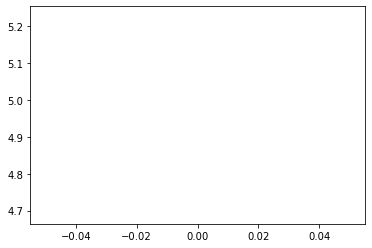

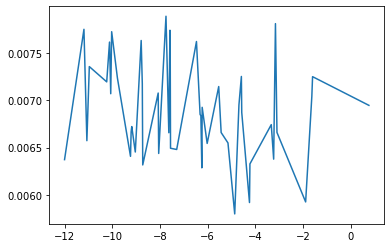

tensor(45030., device='cuda:0')


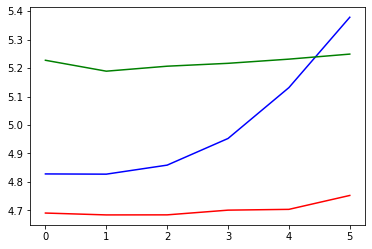

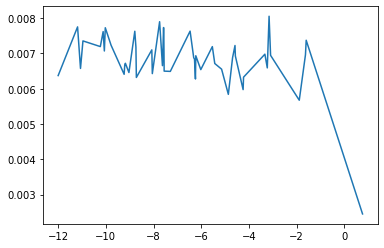

tensor(44496., device='cuda:0')


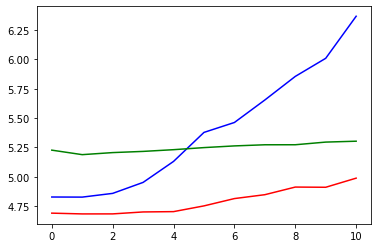

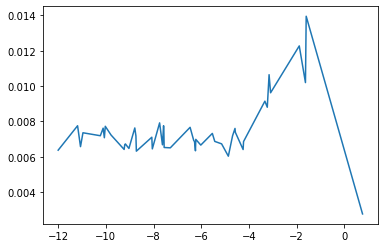

tensor(41590., device='cuda:0')


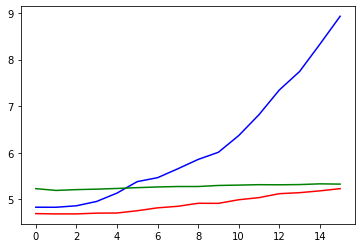

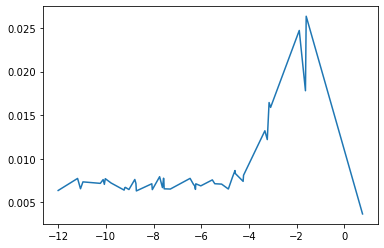

tensor(38375., device='cuda:0')


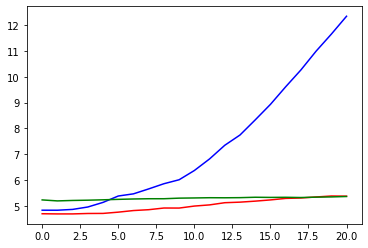

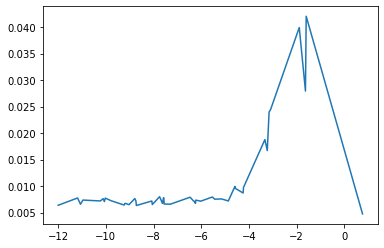

tensor(35875., device='cuda:0')


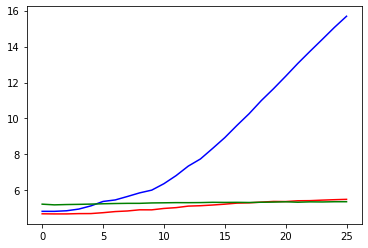

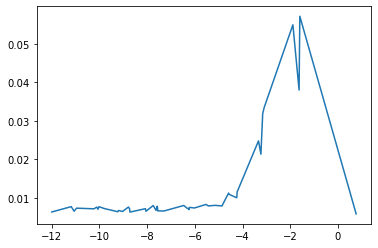

tensor(33759., device='cuda:0')


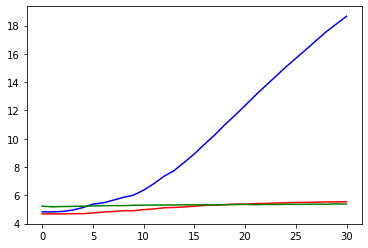

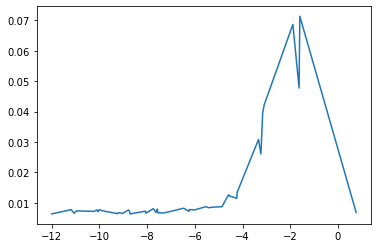

tensor(32056., device='cuda:0')


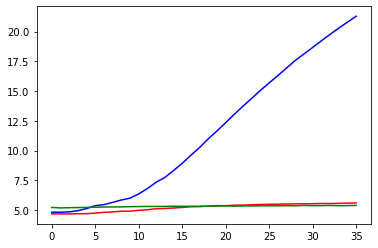

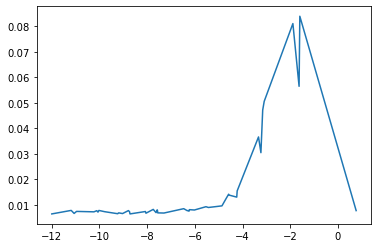

tensor(30541., device='cuda:0')


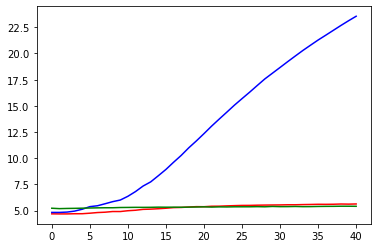

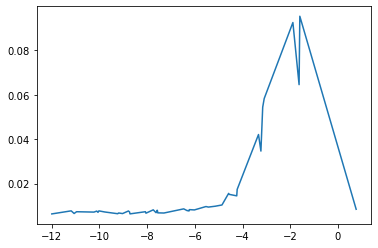

tensor(29607., device='cuda:0')


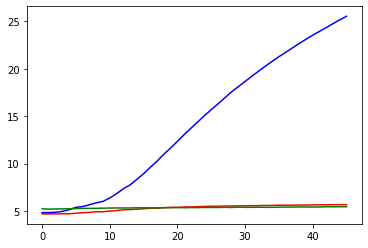

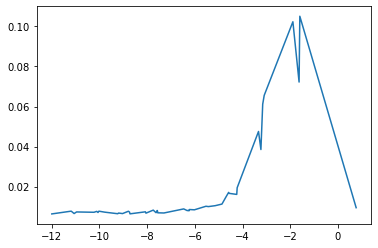

tensor(28559., device='cuda:0')


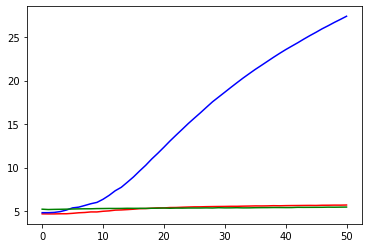

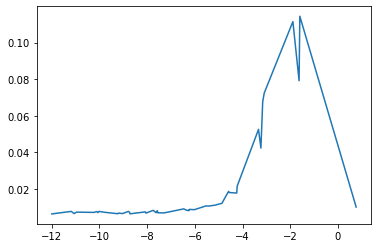

tensor(27643., device='cuda:0')


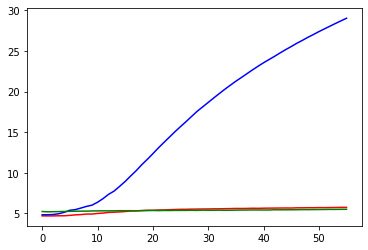

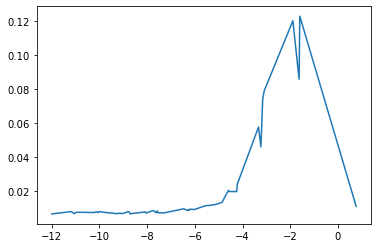

tensor(26812., device='cuda:0')


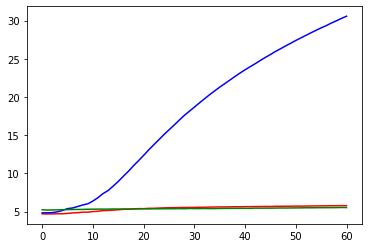

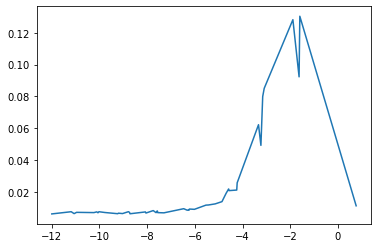

tensor(26096., device='cuda:0')


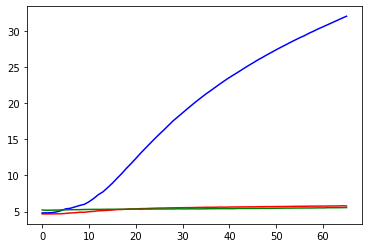

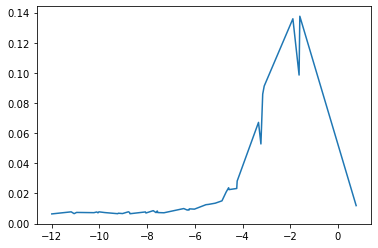

tensor(25383., device='cuda:0')


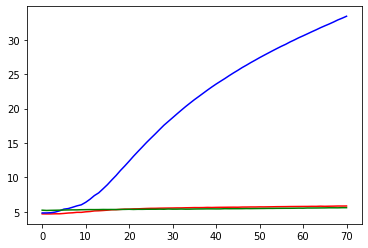

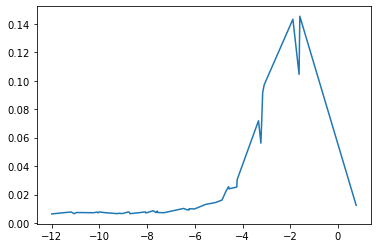

tensor(24702., device='cuda:0')


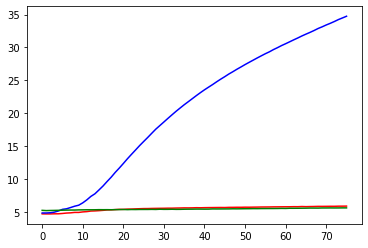

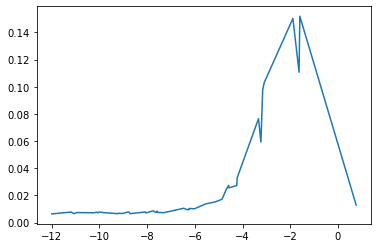

tensor(24017., device='cuda:0')


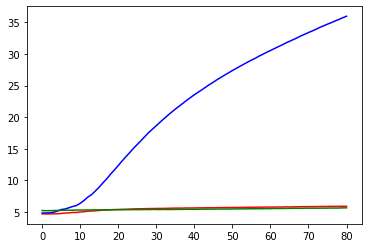

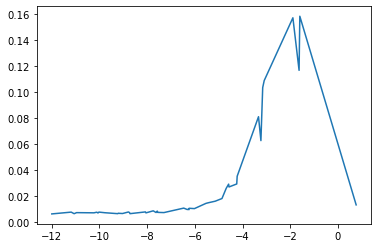

tensor(23458., device='cuda:0')


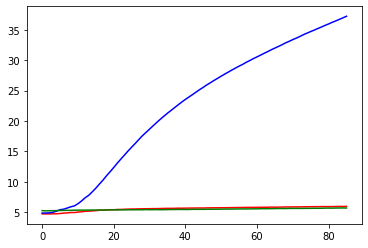

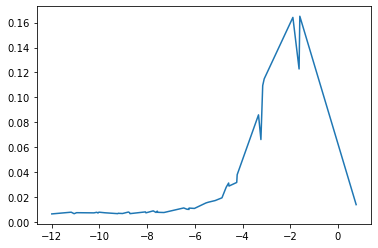

tensor(22854., device='cuda:0')


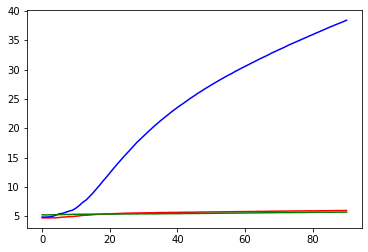

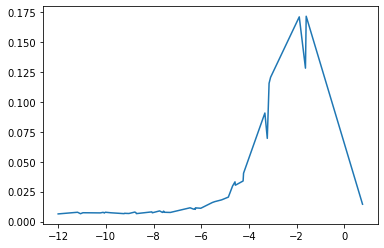

tensor(22179., device='cuda:0')


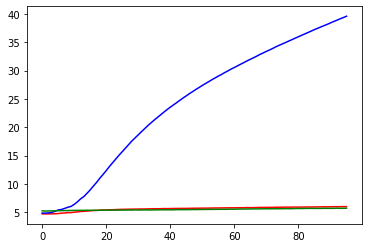

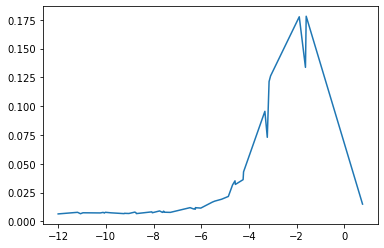

tensor(21583., device='cuda:0')


In [48]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,drop_last = False,shuffle=True)
# classifier = DeepClassifier
classifier = Classifier
model_random = classifier().to(device)
model = classifier().to(device)
optimizer = torch.optim.Adam(list(model.parameters())+list(model_random.parameters()),lr=1e-4)
lossfn = torch.nn.CrossEntropyLoss()
alignment_eigen_random,alignment_random_random,alignment_eigen_real= [],[],[]
maxEpoch = 100

for epoch in range(maxEpoch):
    incorrect = 0 
    for i,(x,y,yrand) in enumerate(train_loader):
        y_pred = model(x.to(device))
        yrand_pred = model_random(x.to(device))
        loss = lossfn(y_pred,y.to(device))+lossfn(yrand_pred,yrand.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        incorrect += (torch.argmax(yrand_pred,dim=1)!=yrand.to(device)).float().sum()
        
        if (i%1000 == 0):
            for x in model_random.conv1.parameters():
                covDataFilters = np.cov(x.detach().cpu().numpy().transpose(0,2,3,1).reshape((x.shape[0],-1)).T)
                break
            alignment_eigen_random.append(misaligment(covDataFilters,DataVecs))
            alignment_random_random.append(misaligment(covDataFilters,RandomVecs))
            
            eigen_mapping = mapping(covDataFilters,DataVecs,DataVals)
            
            for x in model.conv1.parameters():
                covDataFilters = np.cov(x.detach().cpu().numpy().transpose(0,2,3,1).reshape((x.shape[0],-1)).T)
                break
            alignment_eigen_real.append(misaligment(covDataFilters,DataVecs))

    if (epoch%5 == 0):
        plt.plot(np.array(alignment_eigen_random),c='r')
        plt.plot(np.array(alignment_random_random),c='b')
        plt.plot(np.array(alignment_eigen_real),c='g')
        plt.show()
        plt.plot(eigen_mapping[0],eigen_mapping[1])
        plt.show()
        print (incorrect)


In [49]:
t_shallow = [np.array(alignment_eigen_random),np.array(alignment_random_random),np.array(alignment_eigen_real)]
# t_deep = [np.array(alignment_eigen_random),np.array(alignment_random_random),np.array(alignment_eigen_real)]

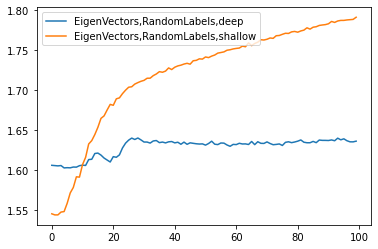

In [52]:
for t,hidden_size in zip([t_deep,t_shallow],['deep','shallow']):
    plt.plot(np.log(t[0]),label="EigenVectors,RandomLabels,%s"%hidden_size)
#     plt.plot(np.log(t[1]),label="RandomVectors,RandomLabels,%s"%hidden_size)
#     plt.plot(np.log(t[2]),label="EigenVectors,RealLabels,%s"%hidden_size)
    plt.legend(loc ="upper left")